Things To Do:
- Take in CollectionState.json versus compiled version from jjerot
- make sheet of own collection

In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600
plt.rcParams.update({'axes.labelsize': 16})
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

In [2]:
def estimate_hdi(posterior, interval_width=0.95):
    # simply find the values that contain 0.95 of the posterior
    norm = posterior/np.sum(posterior)
    low = (1 - interval_width)/2
    high = interval_width + (1 - interval_width)/2
    high_arg = np.argmin(np.abs(np.cumsum(norm)-high))
    low_arg = np.argmin(np.abs(np.cumsum(norm)-low))
    return low_arg, high_arg

def estimate_uncertainty(p_grid, posterior, interval_width=0.95):
    low_arg, high_arg = estimate_hdi(posterior, interval_width=interval_width)
    pos_max = p_grid[posterior.argmax()]
    pos_low = p_grid[low_arg]
    pos_high = p_grid[high_arg]
    #simply find the uncertainty
    low_bound = pos_max - pos_low
    high_bound = pos_high - pos_max
    return low_arg, high_arg, pos_low, pos_high, low_bound, high_bound

def cull_splits(subset, n_cull):
    # remove the earliest n_cull splits
    return subset.sort_values('time')[n_cull:]

def random_cull_splits(subset, n_cull=3):
    #old method now deprecated that we load in time info
    # we need to remove the first split and remove N random earlier ones
    subset = subset[subset['effect']==subset['effect']]
    # if we only want to cull 3
    inkfilter = subset['back'].str.contains('Ink')
    goldfilter = subset['back'].str.contains('Gold')
    kirbyfilter = subset['effect'].str.contains('Kirby')

    drop_filter = ~inkfilter & ~goldfilter & ~kirbyfilter
    drop_indices = np.random.choice(subset[drop_filter].index, n_cull-1, replace=False)
    df_subset = subset.drop(drop_indices)

    return df_subset

As a first go at testing the probability of getting an ink or gold split, we will use some Bayesian estimation with a binomial distribution. A binomial distribution is good for estimating this probability as we have a clear "yes" (the split is inkgold) and "no" (the split is not ink/gold). But unfortunately this is not correct, as we know for certain that splits cannot be duplicated for a character (anymore) so our samples are not [independent](https://en.wikipedia.org/wiki/Bernoulli_trial). Furthermore, our samples are likely biased by the fact that one might tend to stop splitting a card after it has reached a desired outcome. For now, let's see how we do if we treat our split data as independent and identically distributed. 

I am not a statistician, but I can pretend to be one for now. We are going to find the probability for getting a "premium" split using Bayesian updating. The plan is to use each card as an independent data set and update our estimate of the probability of getting a premium split. But first, a little more information on what we are doing.

# It's Bayes'in time...
In short, Bayesian statistics is great for updating our previous understanding of a situation based on new information. We have a **Prior** distribution which captures our previous assumptions about the situation. We have a **Likelihood** which captures our understanding of the new observation. Then we have a **Posterior** which combines our previous understanding updated by our observations. Bayes formula can be shown as these three combined

$$
\mathrm{Posterior} \propto \mathrm{Likelihood}\times\mathrm{Prior}.
$$
We are missing a normalization factor (the Bayesian "**Evidence**") which captures the probability of all possible data outcomes. This is probably easy to copmute for a binomial distribution, but we can drop it for now as a normalization constant. To simplify numbers and plots, I will "normalize" all distributions such that there maximum value is 1. 

First, let's talk about our assumed likelihood: the binomial distribution. The binomial distribution is perfect for this, as we want to find the probability of $k$ successes in $n$ trials with a rate $p$. Here, for a given character we want to know the probability of getting a premium split $p$ based on the fact that we got $k$ premium splits after splitting the card $n$ times. We will use the binomial probaility mass function (which may be familiar to you)
$$
Pr(k|n,p) = {n\choose k}p^k(1-p)^{n-k}.
$$
Here, $Pr(k|n,p)$ can be translated to "what is the probability of $k$ successes given the number of trials $n$ and probability of success $p$". Remember, **THIS IS NOT THE CORRECT FORMULA**. The binomial distribution assumes our data are identical and independently distributed. Our data our not (the possible outcomes depend on previous outcomes as we are drawing split variations without replacement), but we are pretending like they are for this. 

Now we need a Prior. For our first guess, we are going to assume nothing about the probability of getting a premium split and use a Uniform ("uninformative") prior. What this means is that, to start, we are going to assume all values of $p$ are equally probable. Our prior will be 1 for all values of $p$. However (and here comes the cool part about Bayesian statistics) once we have a POSTERIOR for one card, we can use it as the PRIOR for the next card. Written out, 

$$
\mathrm{Posterior}_1 \propto \mathrm{Likelihood_1}\times\mathrm{Uniform}\\
\rightarrow\mathrm{Posterior}_2 \propto \mathrm{Likelihood}_2\times\mathrm{Posterior}_1 \\
\rightarrow\mathrm{Posterior}_3 \propto \mathrm{Likelihood}_3\times\mathrm{Posterior}_2 \\
...\\
\rightarrow\mathrm{Posterior}_i \propto \mathrm{Likelihood}_i\times\mathrm{Posterior}_{i-1} 
$$

In this manner, we can treat each card as its own trial and update our understanding as we progress. 

Let's do a quick example using two cards to layout the rest of the method. Let's say we split Card #1 twelve times and have one gold split and we split Card #2 eight times and got two gold splits. Our first estimate will be based on only Card #1. Remember that the we can only get a gold split on splits five and greater, so we really only have 12-4=8 attempts at getting the gold split. We use our uniform prior and compute the binomial probabilities $\mathrm{Pr}(1|8,p)$ for values of $p$ on the range [0,1]. We assume all values of $p$ are equally likely (and don't pin it to the 10% value comonly quoted or make any assumptions really). In the plots below, you can see our Prior, our Likelihood, and our Posterior $\propto$ Likelihood $\times$ Prior. Here, our Posterior is equal to our Likelihood as we had an uniformative (uniform) prior. The most likely value of $p$ from this first set is 0.13, so we would guess from this that our odds of getting a gold split is roughly 13%. 


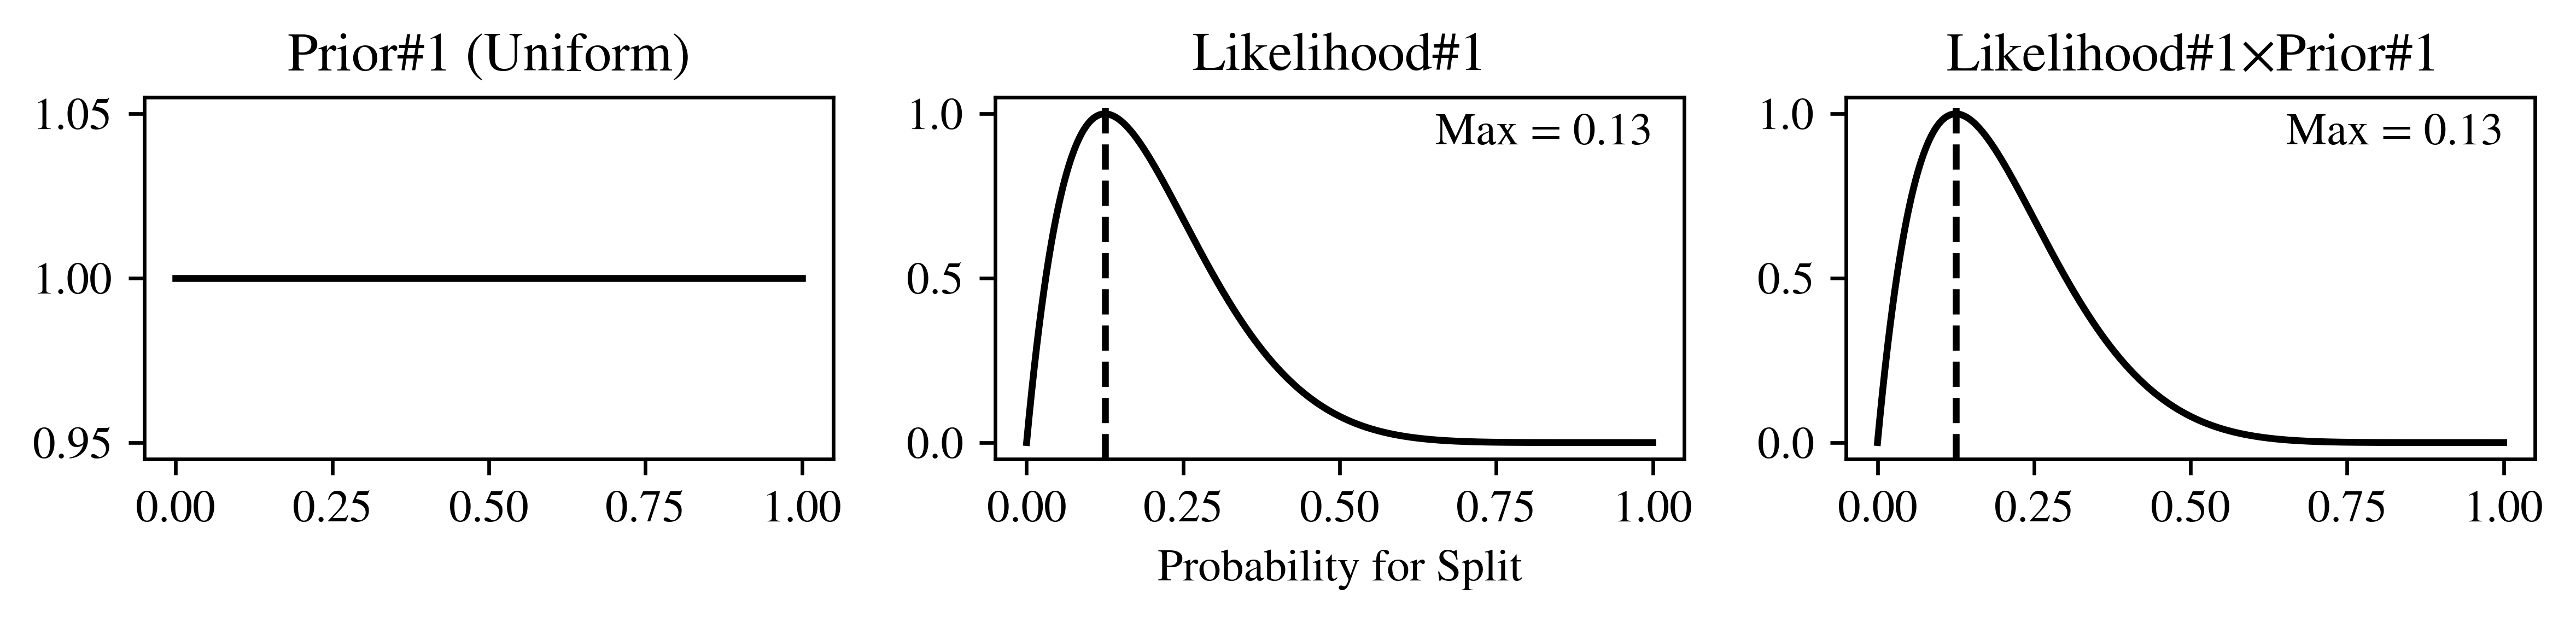

In [3]:
p_grid = np.linspace(0,1,1000)
prior = np.ones(1000)
likelihood1 = scipy.stats.binom.pmf(1,8,p_grid)
posterior1 = likelihood1 * prior
fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 2))
ax[0].plot(p_grid, prior,color='k')
ax[0].set_title('Prior#1 (Uniform)')
ax[1].plot(p_grid, likelihood1/np.max(likelihood1),color='k')
ax[1].axvline(p_grid[likelihood1.argmax()],color='k',linestyle='--')
ax[1].text(1,1,f'Max = {p_grid[likelihood1.argmax()]:.2f}',verticalalignment='top',horizontalalignment='right')
ax[1].set_title('Likelihood#1')
ax[1].set_xlabel('Probability for Split',fontsize=10)
ax[2].plot(p_grid, posterior1/np.max(posterior1),color='k')
ax[2].axvline(p_grid[posterior1.argmax()],color='k',linestyle='--')
ax[2].text(1,1,f'Max = {p_grid[posterior1.argmax()]:.2f}',verticalalignment='top',horizontalalignment='right')
ax[2].set_title(r'Likelihood#1$\times$Prior#1')
fig.tight_layout()

For Card #2, we got two gold splits out of a possible three. Hot streak baby! Now, we are going to use our Posterior from Card #1 as the Prior for Card #2. We got two golds out of a possible 4, so we compute our binomial probabilites $\mathrm{Pr}(2|4,p)$ for values of $p$ on the range [0,1]. We get our Posterior as before, and find the maximum value has been updated to 23%. Dang! 

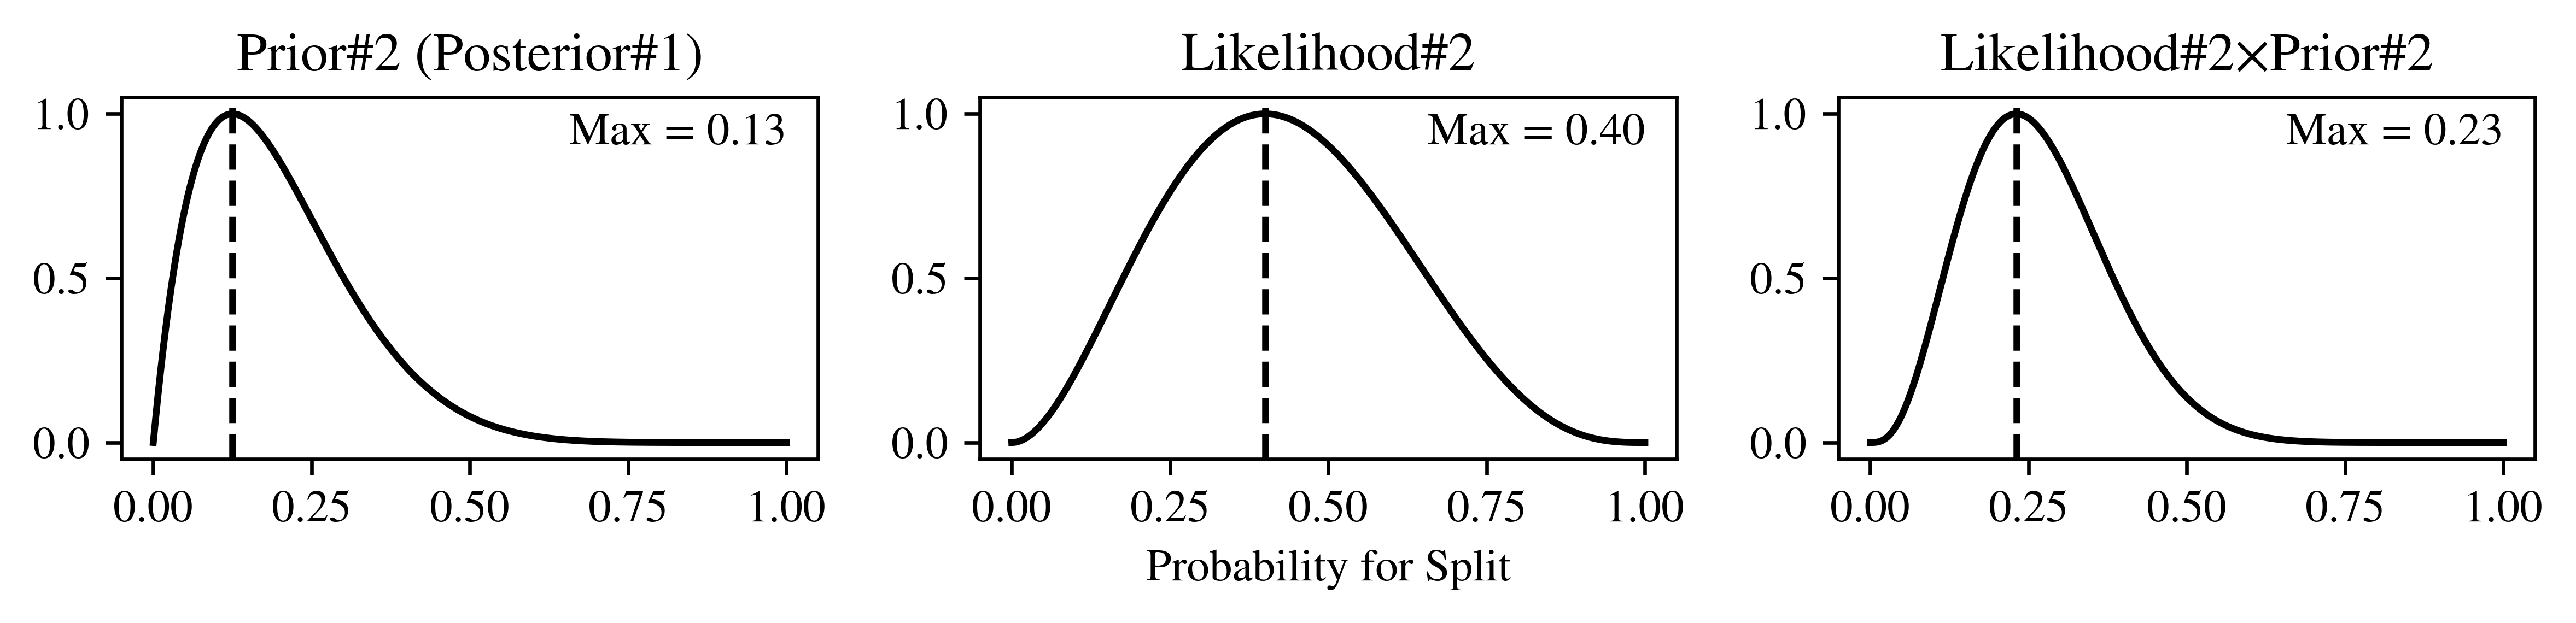

In [4]:
prior = likelihood1/np.linalg.norm(likelihood1)
likelihood2 = scipy.stats.binom.pmf(2,5,p_grid)
posterior2 = likelihood2 * prior
fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 2))
ax[0].plot(p_grid, prior/np.max(prior),color='k')
ax[0].set_title('Prior#2 (Posterior#1)')
ax[0].axvline(p_grid[prior.argmax()],color='k',linestyle='--')
ax[0].text(1,1,f'Max = {p_grid[prior.argmax()]:.2f}',verticalalignment='top',horizontalalignment='right')
ax[1].plot(p_grid, likelihood2/np.max(likelihood2),color='k')
ax[1].axvline(p_grid[likelihood2.argmax()],color='k',linestyle='--')
ax[1].text(1,1,f'Max = {p_grid[likelihood2.argmax()]:.2f}',verticalalignment='top',horizontalalignment='right')
ax[1].set_title('Likelihood#2')
ax[1].set_xlabel('Probability for Split',fontsize=10)
ax[2].plot(p_grid, posterior2/np.max(posterior2),color='k')
ax[2].axvline(p_grid[posterior2.argmax()],color='k',linestyle='--')
ax[2].text(1,1,f'Max = {p_grid[posterior2.argmax()]:.2f}',verticalalignment='top',horizontalalignment='right')
ax[2].set_title(r'Likelihood#2$\times$Prior#2')
fig.tight_layout()

As we do this more and more, we should expect to see our posterior distributions move towards the most likely value of $p$. 

Now, we do this for an entire collection of cards. We will do this with data from jjerot. We will do this for Ink, Gold, and Krackle (all independently), as well as look at probabilities for Ink+Krackle and Gold+Krackle. 

[ 0. 30.  7. 17. 10. 10.  8.  8.  4.  6.  3.  0.  2.  2.  1.  0.  0.  0.
  2.  2.]


Text(0, 0.5, 'Number of Cards with $N$ Splits')

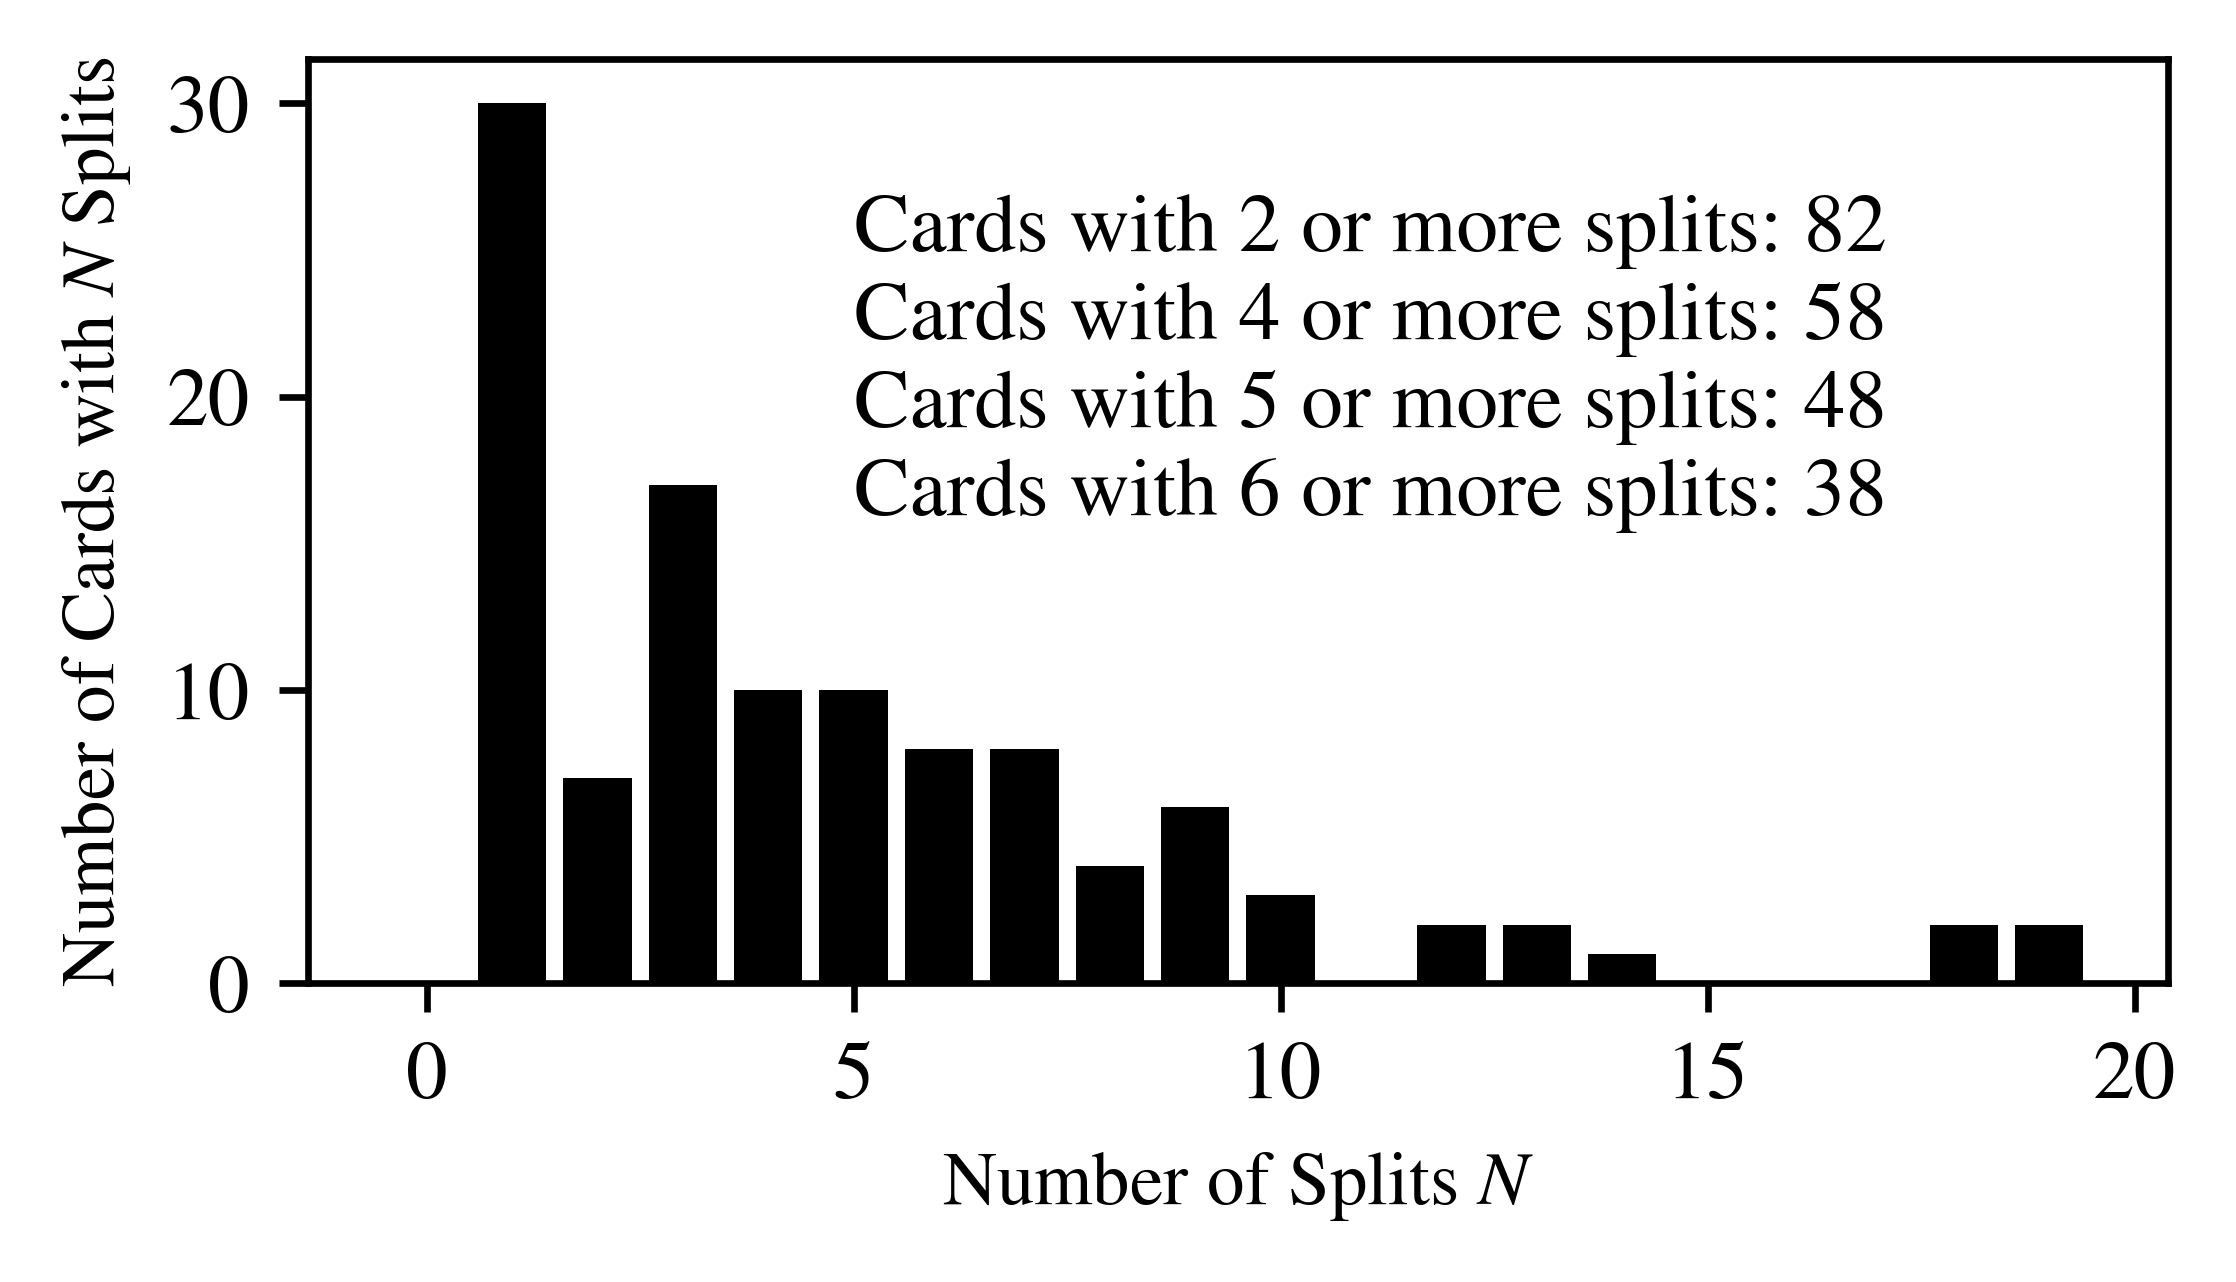

In [5]:

all_cards_master = pd.read_csv('./data/newSplitData.txt', delimiter=' ',header=0,names=['name','back','effect','time'])
all_cards_master['time'] = pd.to_datetime(all_cards_master['time'],format='%Y-%m-%dT%H:%M:%S.%fZ')
all_cards_master = all_cards_master.fillna('None')

n_bins = 20
n_splits_total = np.zeros(n_bins)

for name in all_cards_master['name'].unique():
    subset = all_cards_master[all_cards_master['name']==name]
    n_splits = len(subset)
    n_splits_total[n_splits] +=1
print(n_splits_total)
fig,ax = plt.subplots(figsize=(4,2))
ax.bar(np.arange(n_bins),n_splits_total,color='k')
ax.text(5,25,f"Cards with 2 or more splits: {int(np.sum(n_splits_total[2:]))}")#,color='C1')
ax.text(5,22,f"Cards with 4 or more splits: {int(np.sum(n_splits_total[4:]))}")
ax.text(5,19,f"Cards with 5 or more splits: {int(np.sum(n_splits_total[5:]))}")
ax.text(5,16,f"Cards with 6 or more splits: {int(np.sum(n_splits_total[6:]))}")
ax.set_xlabel(r'Number of Splits $N$',fontsize=9)
ax.set_ylabel(r'Number of Cards with $N$ Splits',fontsize=9)


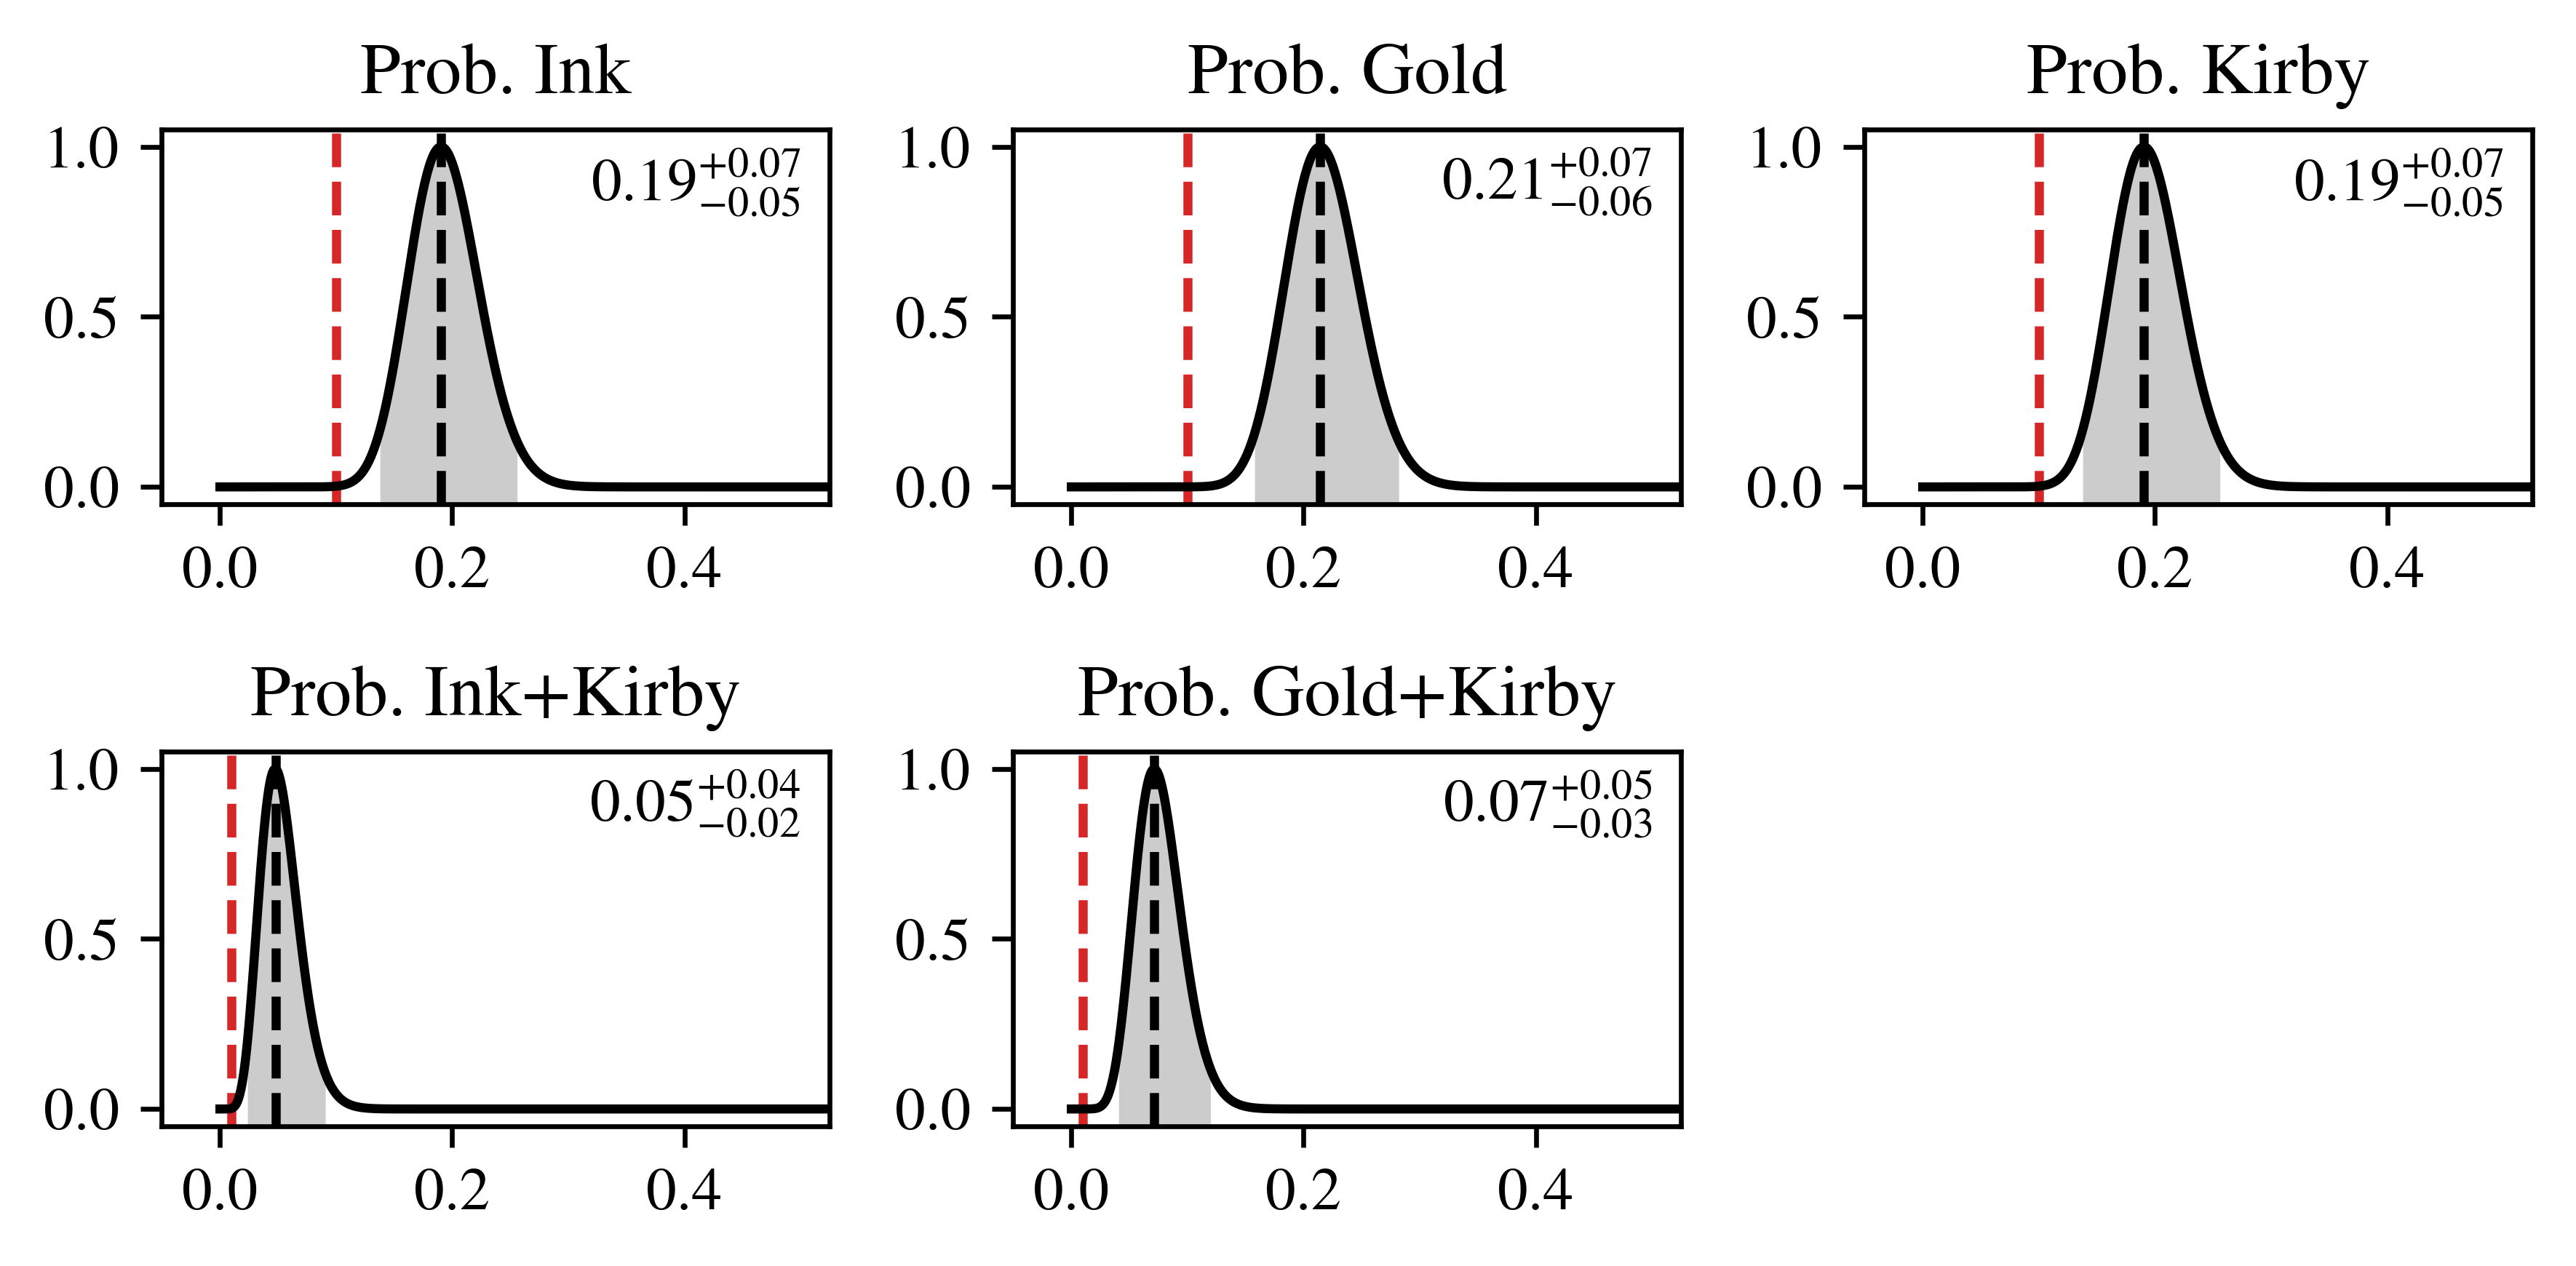

In [6]:
# let's mash these all together ###NEW VERSION###
# What are the "premium" probs on and after sixth split
all_cards = all_cards_master.copy()

p_grid = np.linspace(0,1,1000)
gold_prior = np.ones(1000)
ink_prior = np.ones(1000)
kirby_prior = np.ones(1000)
goldkirby_prior = np.ones(1000)
inkkirby_prior = np.ones(1000)
nominals = [0.1,0.1,0.1,0.1*0.1,0.1*0.1]

for name in all_cards['name'].unique():
    subset = all_cards[all_cards['name']==name]
    n_splits_total = len(subset)
    n_cull = 5
    if n_splits_total < n_cull+1:
        continue

    subset = cull_splits(subset, n_cull=n_cull)
    n_poss = len(subset)

    n_ink = 0
    n_gold = 0
    n_kirby = 0
    n_inkkirby = 0
    n_goldkirby = 0


    for sub in subset.iterrows():
        # always cummulate backs
        if sub[1]['back']=='Ink':
            n_ink += 1
        if sub[1]['back']=='GoldFoil':
            n_gold += 1
        # cummulate kirbys as well
        if 'Kirby' in sub[1]['effect']:
            n_kirby += 1
            if sub[1]['back']=='Ink':
                n_inkkirby += 1
            if sub[1]['back']=='GoldFoil':
                n_goldkirby += 1
    
    ink_likelihood = scipy.stats.binom.pmf(n_ink,n_poss,p_grid)
    ink_posterior = ink_likelihood * ink_prior / np.max(ink_likelihood * ink_prior)
    #print(p_grid[posterior.argmax()])
    ink_prior = ink_posterior

    gold_likelihood = scipy.stats.binom.pmf(n_gold,n_poss,p_grid)
    gold_posterior = gold_likelihood * gold_prior / np.max(gold_likelihood * gold_prior)
    gold_prior = gold_posterior

    kirby_likelihood = scipy.stats.binom.pmf(n_kirby, n_poss,p_grid)
    kirby_posterior = kirby_likelihood * kirby_prior / np.max(kirby_likelihood * kirby_prior)
    kirby_prior = kirby_posterior

    inkkirby_likelihood = scipy.stats.binom.pmf(n_inkkirby, n_poss,p_grid)
    inkkirby_posterior = inkkirby_likelihood * inkkirby_prior / np.max(inkkirby_likelihood * inkkirby_prior)
    inkkirby_prior = inkkirby_posterior

    goldkirby_likelihood = scipy.stats.binom.pmf(n_goldkirby, n_poss,p_grid)
    goldkirby_posterior = goldkirby_likelihood * goldkirby_prior / np.max(goldkirby_likelihood * goldkirby_prior)
    goldkirby_prior = goldkirby_posterior
    
fig,ax = plt.subplots(nrows=2, ncols=3, figsize=(6, 3))
text_x = 0.5
text_y = 1
titles = ['Prob. Ink','Prob. Gold','Prob. Kirby','Prob. Ink+Kirby', 'Prob. Gold+Kirby']
posteriors = [ink_posterior,gold_posterior,kirby_posterior,inkkirby_posterior,goldkirby_posterior]

for i in np.arange(5):
    temp_ax = ax.flatten()[i]
    temp_posterior = posteriors[i]
    temp_ax.set_xlim(-0.05,text_x+text_x*0.05)
    temp_ax.set_ylim(-0.05,1.05)
    temp_ax.axvline(p_grid[temp_posterior.argmax()],color='k',linestyle='--')
    temp_ax.axvline(nominals[i],color='C3',linestyle='--')
    temp_ax.plot(p_grid, temp_posterior,color='k')
    temp_ax.set_title(titles[i])
    low_arg, high_arg, pos_low, pos_high, low_bound, high_bound = estimate_uncertainty(p_grid, temp_posterior, interval_width=0.95)
    fill_x = p_grid[low_arg:high_arg+1]
    fill_y = temp_posterior[low_arg:high_arg+1]
    temp_ax.fill_between(fill_x,fill_y,-1*np.ones(len(fill_x)),color='k',alpha=0.2,edgecolor=None)
    temp_ax.text(text_x,text_y,f'${p_grid[temp_posterior.argmax()]:.2f}^{{+{high_bound:0.2f}}}_{{-{low_bound:0.2f}}}$',verticalalignment='top',horizontalalignment='right')

fig.delaxes(ax.flatten()[-1])
fig.tight_layout()

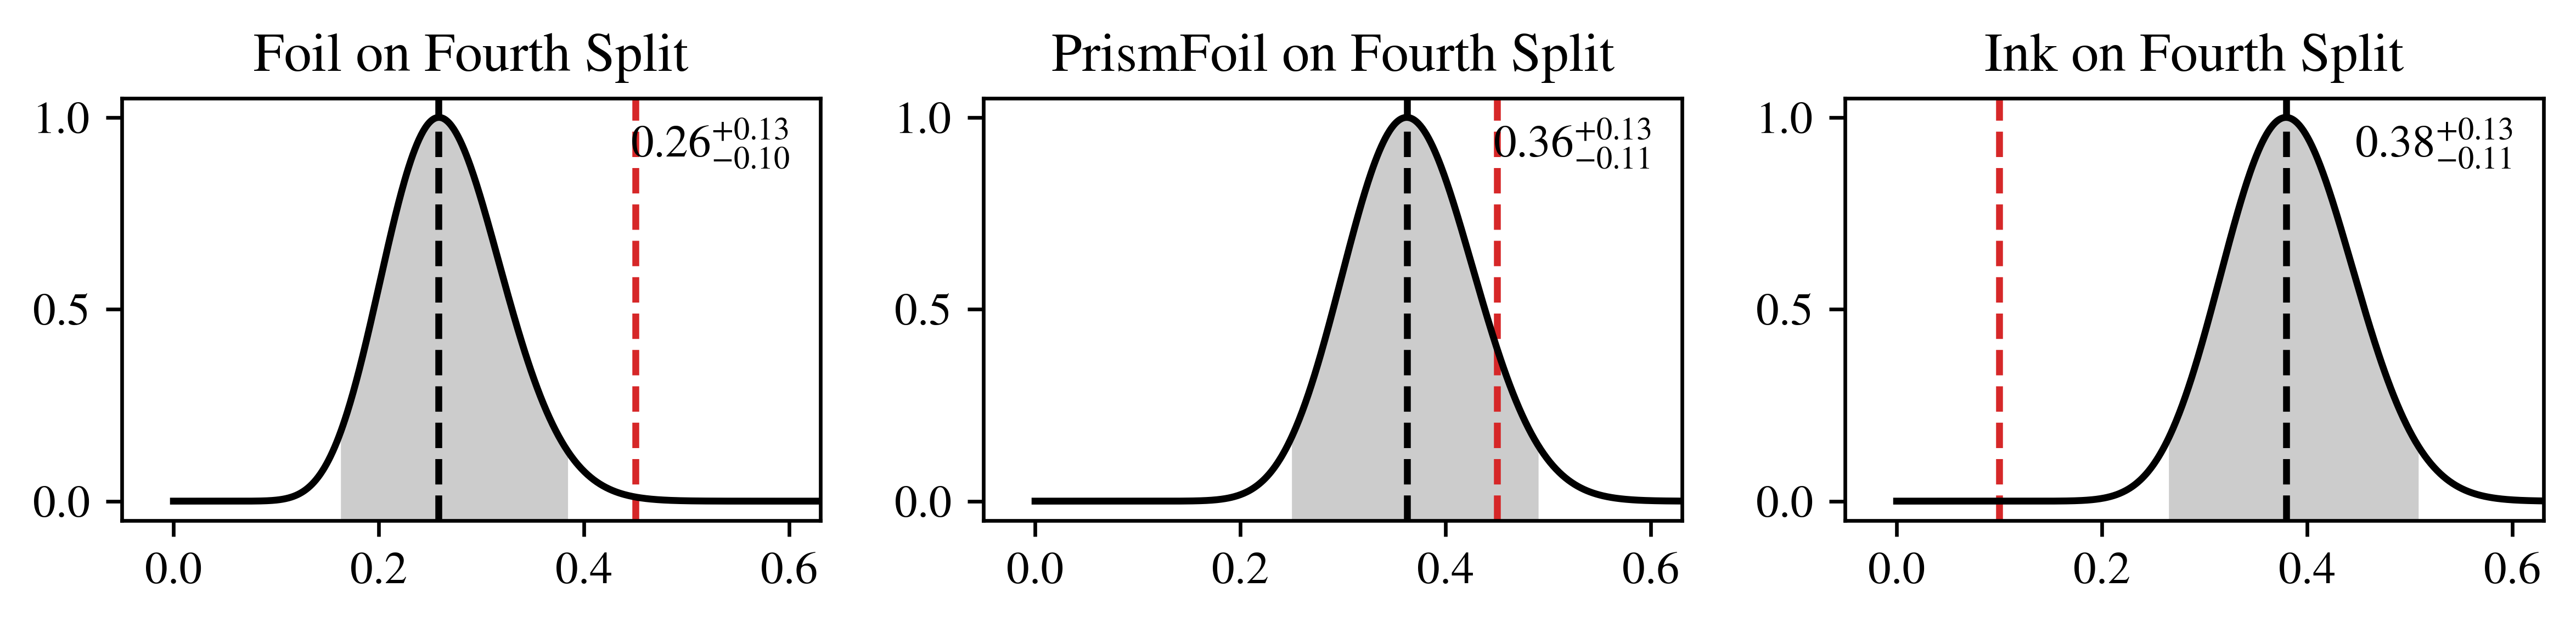

In [7]:
# back probs on fourth split
p_grid = np.linspace(0,1,1000)
colors = ['Foil', 'PrismFoil', 'Ink']
priors = [np.ones(1000)] * 3
posteriors = [np.ones(1000)] * 3
nominals = [0.45,0.45,0.1]
all_cards = all_cards_master.copy()


for name in all_cards['name'].unique():
    subset = all_cards[all_cards['name']==name]
    n_splits = len(subset)
    # if we do not have enough splits to get to ink, go to next card
    if n_splits < 4:
        continue
    # first, compute ink
    inkset = cull_splits(subset,n_cull=3)
    fourth_split = inkset.iloc[0]

    n_poss_color = 1
    counts = np.zeros(len(colors))

    for i in range(len(colors)):
        if colors[i] == fourth_split['back']:
            counts[i] += 1
            #print(colors[i],sub[1]['back'],counts[i])
    #print(name)
    for i in range(len(colors)):
        # print(name, colors[i], counts[i],n_poss_color)
        likelihood = scipy.stats.binom.pmf(counts[i],n_poss_color,p_grid)
        posteriors[i] = likelihood * priors[i] / np.max(likelihood * priors[i])
        priors[i] = posteriors[i]

    
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 2))
text_x = 0.6
text_y = 1
titles = colors

for i in np.arange(len(colors)):
    temp_ax = ax.flatten()[i]
    temp_posterior = posteriors[i]
    temp_ax.set_xlim(-0.05,text_x+text_x*0.05)
    temp_ax.set_ylim(-0.05,1.05)
    ax[i].axvline(p_grid[temp_posterior.argmax()],color='k',linestyle='--')
    ax[i].axvline(nominals[i],color='C3',linestyle='--')
    temp_ax.plot(p_grid, temp_posterior,color='k')
    temp_ax.set_title(titles[i]+' on Fourth Split')
    # temp_ax.axvline(p_grid[temp_posterior.argmax()],color='k',linestyle='--')
    low_arg, high_arg, pos_low, pos_high, low_bound, high_bound = estimate_uncertainty(p_grid, temp_posterior, interval_width=0.95)
    fill_x = p_grid[low_arg:high_arg+1]
    fill_y = temp_posterior[low_arg:high_arg+1]
    temp_ax.fill_between(fill_x,fill_y,-1*np.ones(len(fill_x)),color='k',alpha=0.2,edgecolor=None)
    temp_ax.text(text_x,text_y,f'${p_grid[temp_posterior.argmax()]:.2f}^{{+{high_bound:0.2f}}}_{{-{low_bound:0.2f}}}$',verticalalignment='top',horizontalalignment='right')

fig.tight_layout()

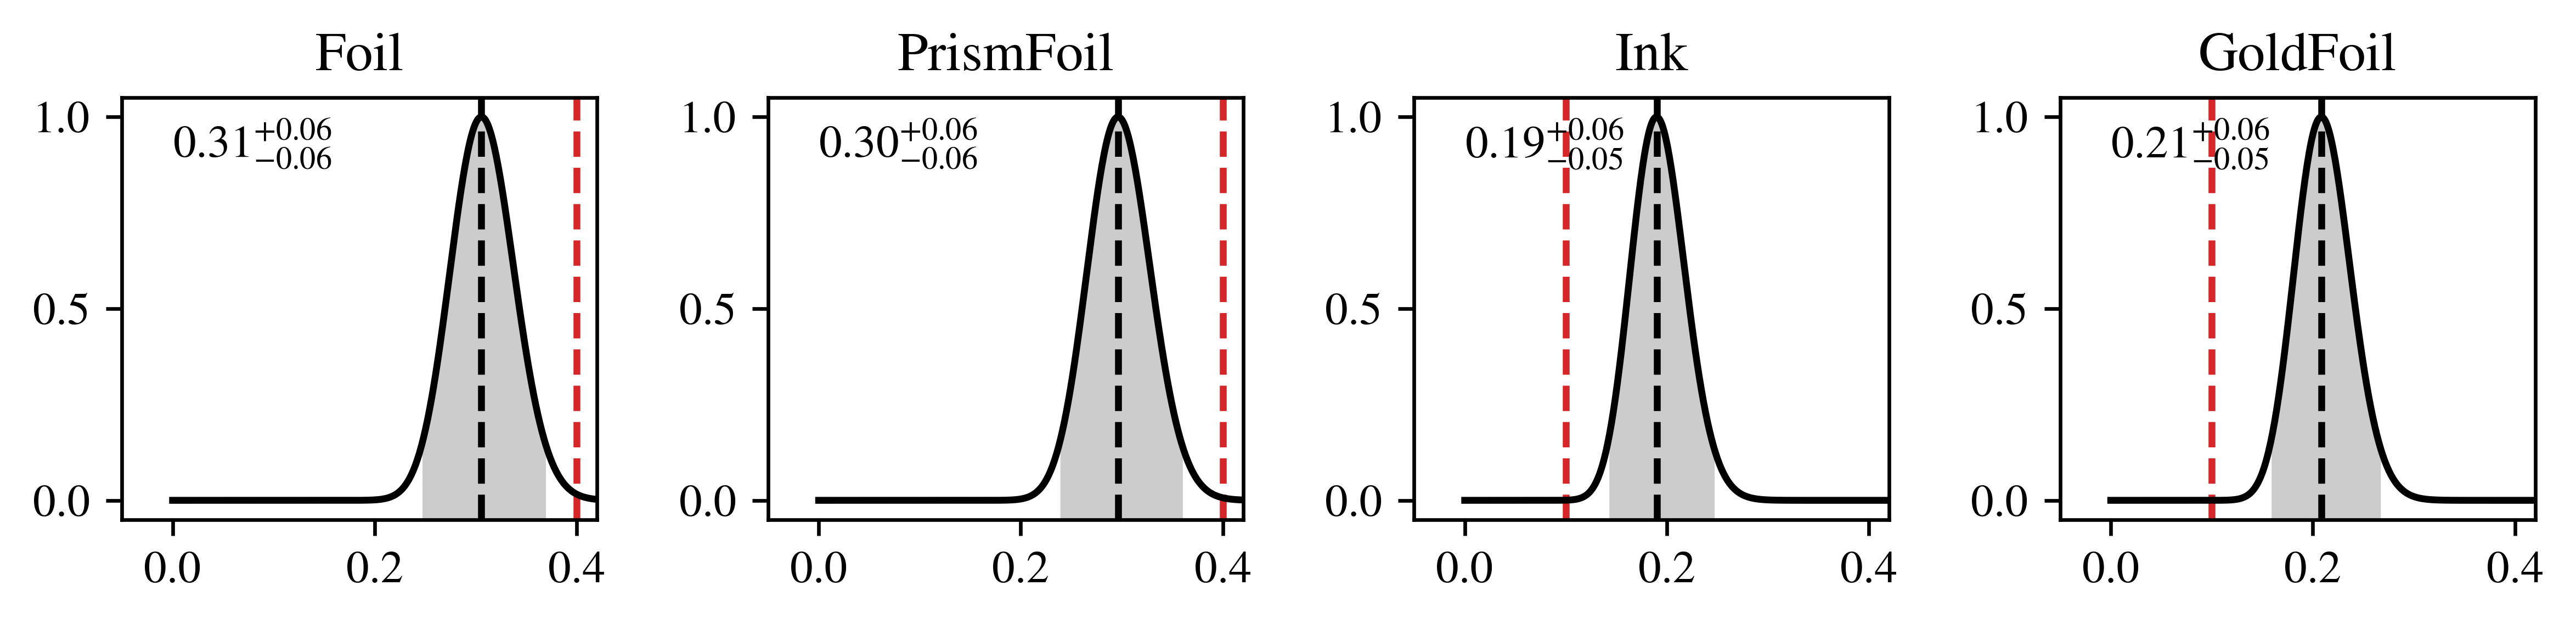

In [8]:
# background probs on or after fifth split
p_grid = np.linspace(0,1,1000)
colors = ['Foil', 'PrismFoil', 'Ink', 'GoldFoil']
priors = [np.ones(1000)] * 4
posteriors = [np.ones(1000)] * 4
nominals = [0.4,0.4,0.1,0.1]
all_cards = all_cards_master.copy()


for name in all_cards['name'].unique():
    subset = all_cards[all_cards['name']==name]
    n_splits = len(subset)
    n_cull = 4
    # if we do not have enough splits to get to gold, go to next card
    # we will only look at probas post gold being possible
    if n_splits < n_cull+1:
        continue
    # There was a card that was throwing an issue, can't cull more than available.
    # this means there is a card that had an filter list that was too large for some reason
    
    subset = cull_splits(subset,n_cull=n_cull)

    # first, compute ink
    n_poss_color = len(subset)
    counts = np.zeros(len(colors))

    for sub in subset.iterrows():
        #loop over backs
        #print(sub)
        for i in range(len(colors)):
            if colors[i] == sub[1]['back']:
                counts[i] += 1
                #print(colors[i],sub[1]['back'],counts[i])
    #print(name)
    for i in range(len(colors)):
        # print(name, colors[i], counts[i],n_poss_color)
        likelihood = scipy.stats.binom.pmf(counts[i],n_poss_color,p_grid)
        posteriors[i] = likelihood * priors[i] / np.max(likelihood * priors[i])
        priors[i] = posteriors[i]

    
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(8, 2))
text_x = 0.4
text_y = 1
titles = colors

for i in np.arange(len(colors)):
    temp_ax = ax.flatten()[i]
    temp_posterior = posteriors[i]
    temp_ax.set_xlim(-0.05,text_x+text_x*0.05)
    temp_ax.set_ylim(-0.05,1.05)
    ax[i].axvline(p_grid[temp_posterior.argmax()],color='k',linestyle='--')
    ax[i].axvline(nominals[i],color='C3',linestyle='--')
    temp_ax.plot(p_grid, temp_posterior,color='k')
    temp_ax.set_title(titles[i])
    # temp_ax.axvline(p_grid[temp_posterior.argmax()],color='k',linestyle='--')
    low_arg, high_arg, pos_low, pos_high, low_bound, high_bound = estimate_uncertainty(p_grid, temp_posterior, interval_width=0.95)
    fill_x = p_grid[low_arg:high_arg+1]
    fill_y = temp_posterior[low_arg:high_arg+1]
    temp_ax.fill_between(fill_x,fill_y,-1*np.ones(len(fill_x)),color='k',alpha=0.2,edgecolor=None)
    temp_ax.text(text_x-text_x,text_y,f'${p_grid[temp_posterior.argmax()]:.2f}^{{+{high_bound:0.2f}}}_{{-{low_bound:0.2f}}}$',verticalalignment='top',horizontalalignment='left')

fig.tight_layout()

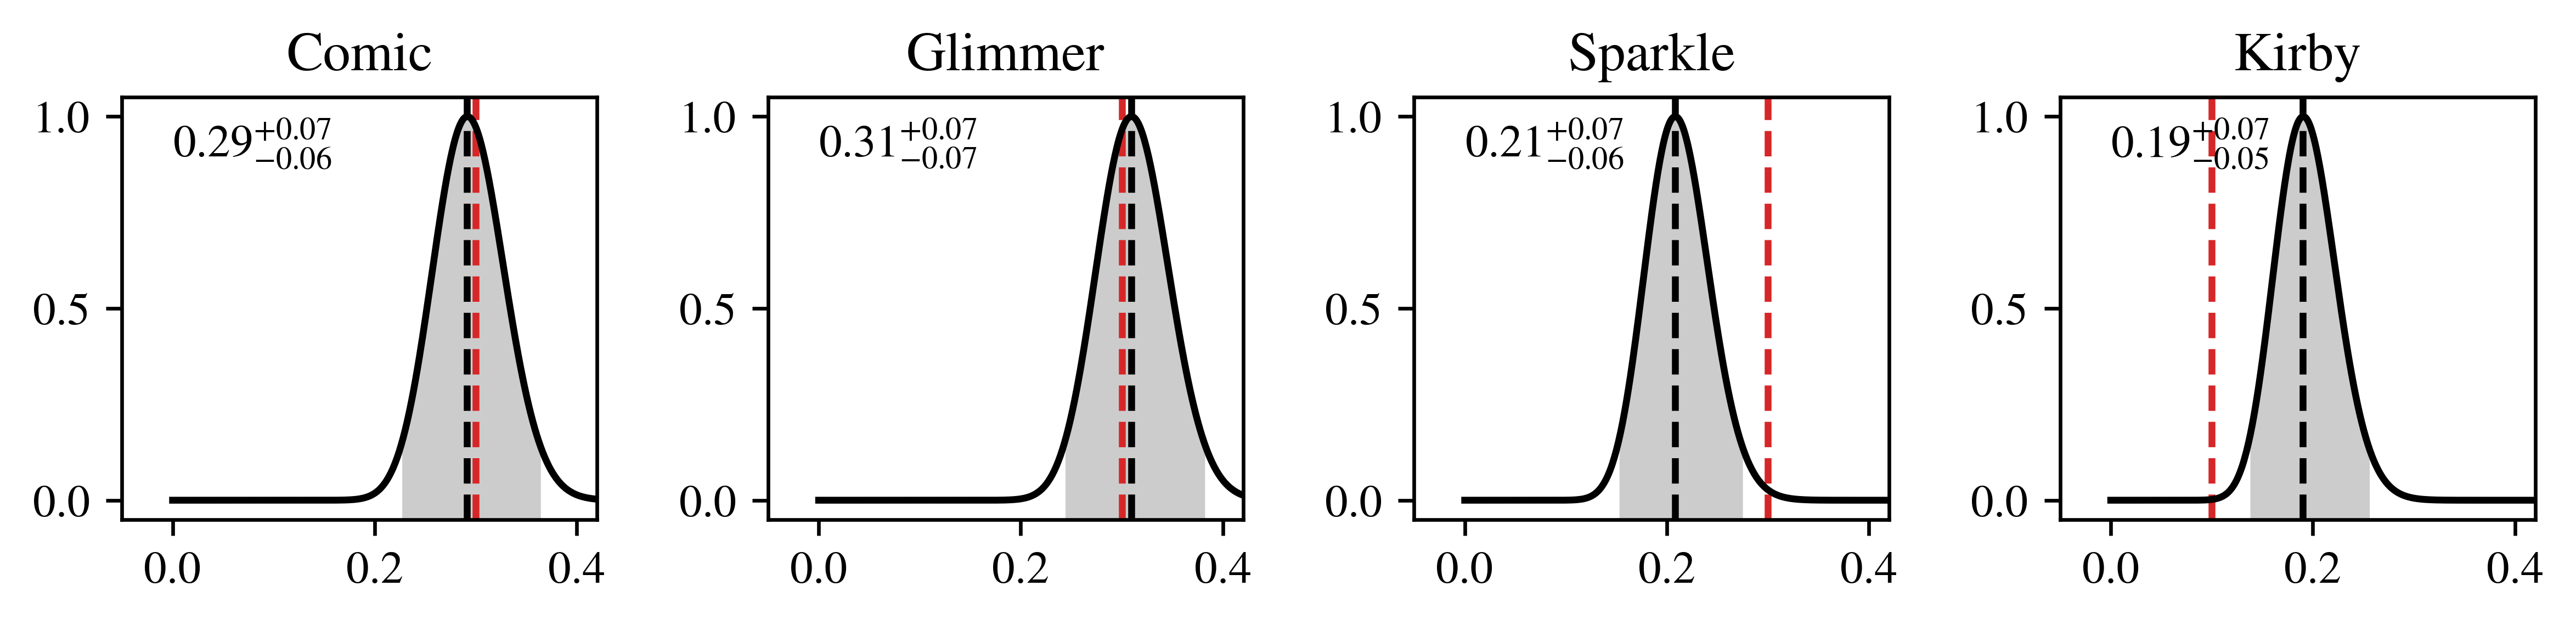

In [9]:
# effect probs after sixth split
p_grid = np.linspace(0,1,1000)
colors = ['Comic', 'Glimmer', 'Sparkle', 'Kirby']
priors = [np.ones(1000)] * 4
posteriors = [np.ones(1000)] * 4
nominals = [0.3, 0.3, 0.3, 0.1]
all_cards = all_cards_master.copy()


for name in all_cards['name'].unique():
    subset = all_cards[all_cards['name']==name]
    n_splits = len(subset)
    n_cull = 5
    # if we do not have enough splits to get to gold, go to next card
    # we will only look at probas post gold being possible
    if n_splits < n_cull+1:
        continue
    # There was a card that was throwing an issue, can't cull more than available.
    # this means there is a card that had an filter list that was too large for some reason
    random_cull = False
    if random_cull:
        try:
            subset = random_cull_splits(subset,n_cull=n_cull)
        except:
            continue
    else: 
        subset = cull_splits(subset, n_cull=n_cull)
    # first, compute ink
    n_poss_color = len(subset)
    counts = np.zeros(len(colors))

    for sub in subset.iterrows():
        #loop over backs
        #print(sub)
        for i in range(len(colors)):
            if colors[i] in sub[1]['effect']:
                counts[i] += 1
                #print(colors[i],sub[1]['back'],counts[i])
    #print(name)
    for i in range(len(colors)):
        # print(name, colors[i], counts[i],n_poss_color)
        likelihood = scipy.stats.binom.pmf(counts[i],n_poss_color,p_grid)
        posteriors[i] = likelihood * priors[i] / np.max(likelihood * priors[i])
        priors[i] = posteriors[i]

    
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(8, 2))
text_x = 0.4
text_y = 1
titles = colors

for i in np.arange(len(colors)):
    temp_ax = ax.flatten()[i]
    temp_posterior = posteriors[i]
    temp_ax.set_xlim(-0.05,text_x+text_x*0.05)
    temp_ax.set_ylim(-0.05,1.05)
    ax[i].axvline(p_grid[temp_posterior.argmax()],color='k',linestyle='--')
    ax[i].axvline(nominals[i],color='C3', linestyle='--')
    temp_ax.plot(p_grid, temp_posterior, color='k')
    temp_ax.set_title(titles[i])
    low_arg, high_arg, pos_low, pos_high, low_bound, high_bound = estimate_uncertainty(p_grid, temp_posterior, interval_width=0.95)
    fill_x = p_grid[low_arg:high_arg+1]
    fill_y = temp_posterior[low_arg:high_arg+1]
    temp_ax.fill_between(fill_x,fill_y,-1*np.ones(len(fill_x)),color='k',alpha=0.2,edgecolor=None)
    temp_ax.text(text_x-text_x,text_y,f'${p_grid[temp_posterior.argmax()]:.2f}^{{+{high_bound:0.2f}}}_{{-{low_bound:0.2f}}}$',verticalalignment='top',horizontalalignment='left')

fig.tight_layout()

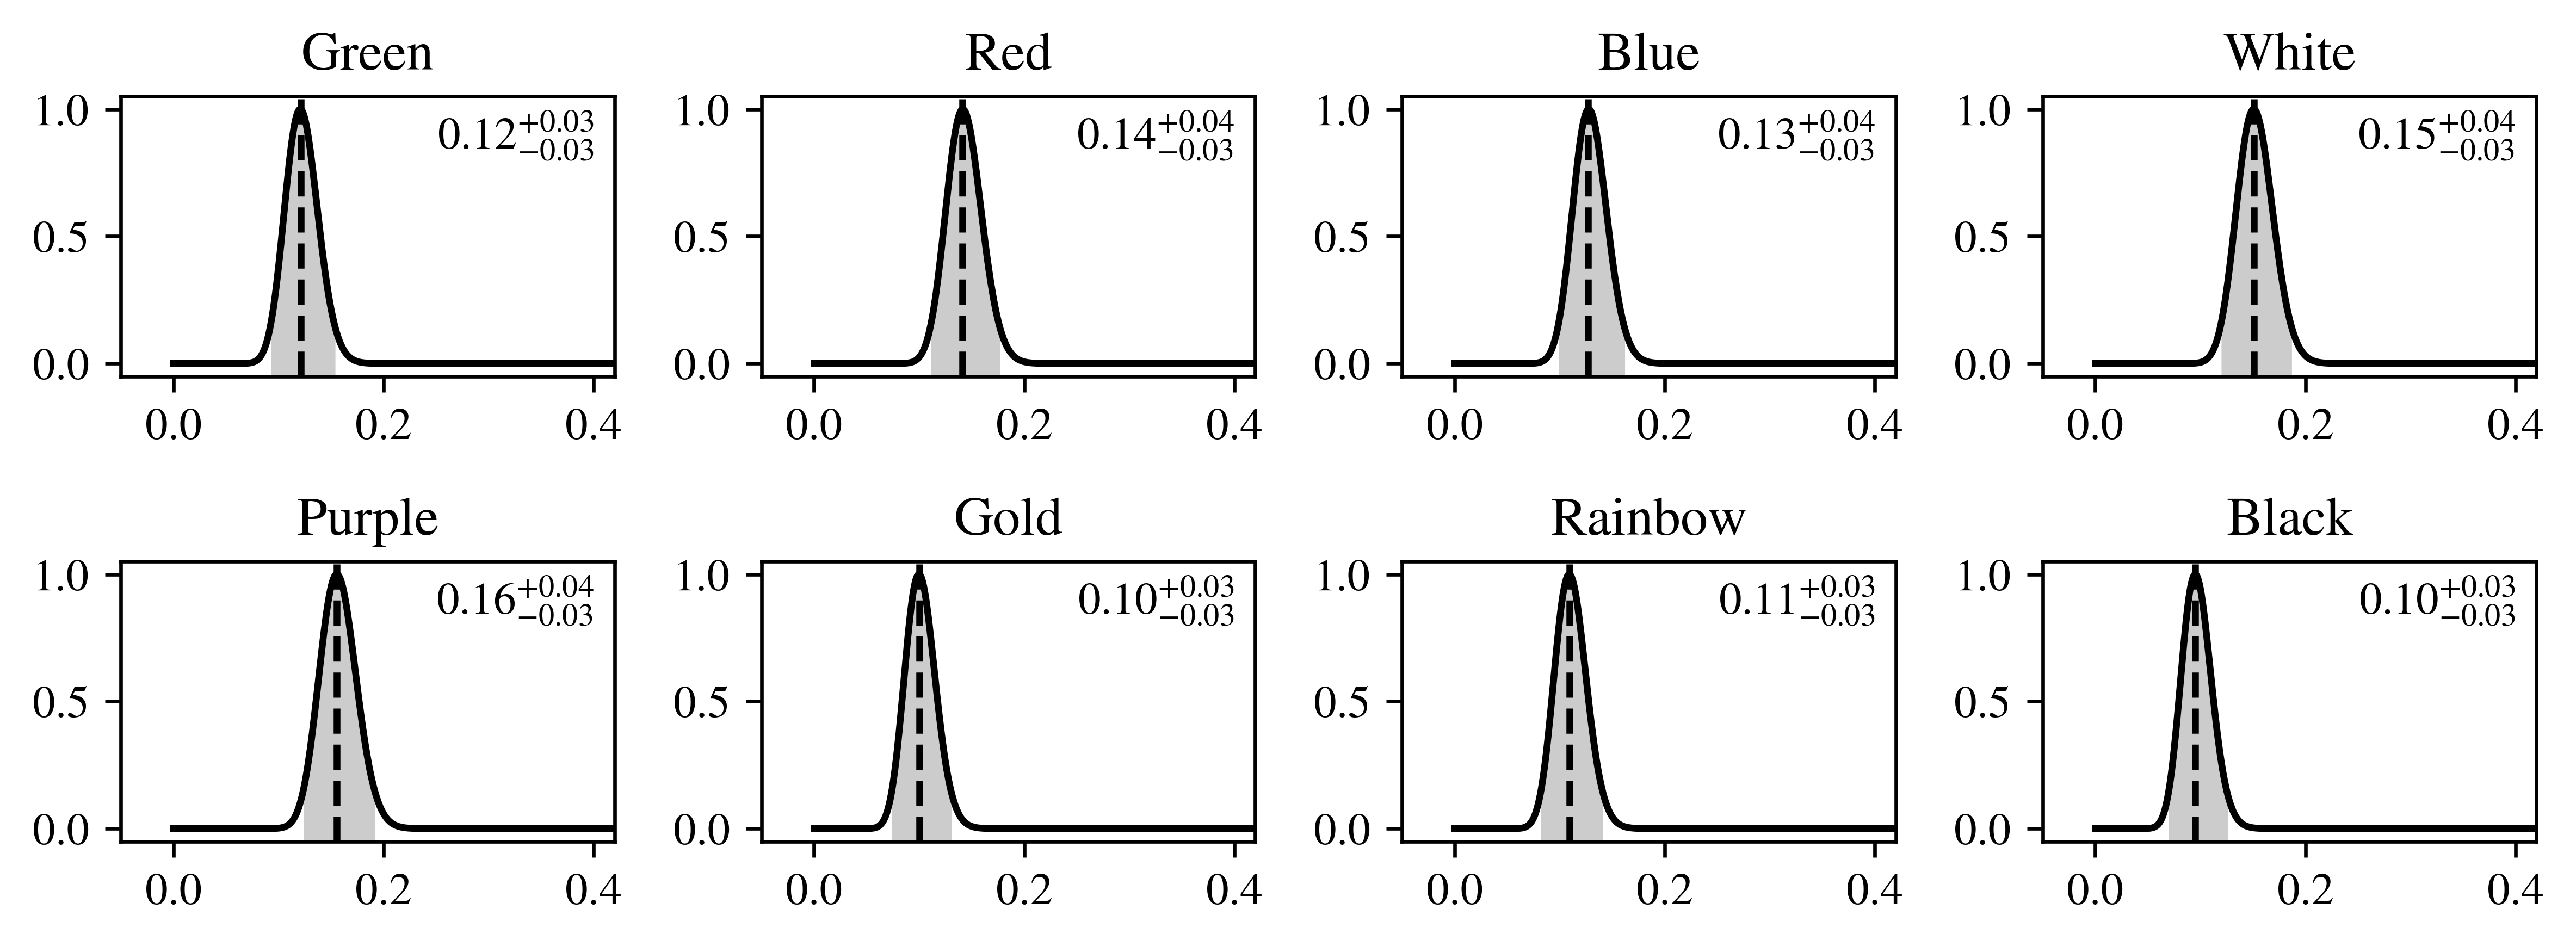

In [10]:
# color probs on or after second split
p_grid = np.linspace(0,1,1000)
colors = ['Green','Red', 'Blue', 'White', 'Purple', 'Gold', 'Rainbow', 'Black']
priors = [np.ones(1000)] * 8
posteriors = [np.ones(1000)] * 8
all_cards = all_cards_master.copy()


for name in all_cards['name'].unique():
    subset = all_cards[all_cards['name']==name]
    n_splits = len(subset)
    n_cull = 1
    # if we do not have enough splits to get to ink, go to next card
    if n_splits < n_cull+1:
        continue

    subset = cull_splits(subset, n_cull=n_cull)
    # first, compute ink
    n_poss_color = n_splits - n_cull
    counts = np.zeros(len(colors))

    for sub in subset.iterrows():
        #print(sub[1]['effect'])
        #filter nan
        if sub[1]['effect'] == sub[1]['effect']:
            #loop over colors
            for i in range(len(colors)):
                if colors[i] in sub[1]['effect']:
                    counts[i] += 1

    for i in range(len(colors)):
        likelihood = scipy.stats.binom.pmf(counts[i],n_poss_color,p_grid)
        posteriors[i] = likelihood * priors[i] / np.max(likelihood * priors[i])
        priors[i] = posteriors[i]

    
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8, 3))
text_x = 0.4
text_y = 1
titles = colors

for i in np.arange(len(colors)):
    temp_ax = ax.flatten()[i]
    temp_posterior = posteriors[i]
    temp_ax.set_xlim(-0.05,text_x+text_x*0.05)
    temp_ax.set_ylim(-0.05,1.05)
    temp_ax.plot(p_grid, temp_posterior, color='k')
    temp_ax.set_title(titles[i])
    temp_ax.axvline(p_grid[temp_posterior.argmax()],color='k',linestyle='--')
    low_arg, high_arg, pos_low, pos_high, low_bound, high_bound = estimate_uncertainty(p_grid, temp_posterior, interval_width=0.95)
    fill_x = p_grid[low_arg:high_arg+1]
    fill_y = temp_posterior[low_arg:high_arg+1]
    temp_ax.fill_between(fill_x,fill_y,-1*np.ones(len(fill_x)),color='k',alpha=0.2,edgecolor=None)
    temp_ax.text(text_x,text_y,f'${p_grid[temp_posterior.argmax()]:.2f}^{{+{high_bound:0.2f}}}_{{-{low_bound:0.2f}}}$',verticalalignment='top',horizontalalignment='right')

fig.tight_layout()